<h1> MIRNet Inference</h1>

This notebook shows the the process of inferencing for the **MIRNet** model as proposed by [Learning Enriched Features for Real Image Restoration and Enhancement](https://arxiv.org/pdf/2003.06792v2.pdf) by Zamir et al. This model is capable of enhancing low-light images upto a great extent.

<h2>A bit about the architecture</h2>

The MIRNet presents a novel architecture with the collective goals of maintaining high-resolution representations through the entire network, and
receiving strong contextual information from the low-resolution representations.

The core of this approach is a multi-scale residual block containing the following key elements:
- parallel multi-resolution convolution streams for extracting multi-scale features
- information exchange across the multi-resolution streams
- spatial and channel attention mechanisms for capturing contextual information
- attention based multi-scale feature aggregation.

![](https://i.imgur.com/VOzfG9a.png)
<p align="center">
<small>Framework of MIRNet</small>
</p>

The figure above shows the framework of the proposed network MIRNet that learns enriched feature representations for image restoration and enhancement.

<h2>Examples</h2>

<p align="center">
<img src="https://github.com/soumik12345/MIRNet/raw/master/assets/lol_results.gif"</img><br>
<small><a href="https://github.com/soumik12345/MIRNet/blob/master/assets/lol_results.gif">Source</a></small>
</p>

Model training code and pre-trained weights are provided by Soumik through [this repository](https://github.com/soumik12345/MIRNet/).

## Setup

In [1]:
!git clone https://github.com/soumik12345/MIRNet
%cd MIRNet

Cloning into 'MIRNet'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 251 (delta 10), reused 8 (delta 8), pack-reused 237
Receiving objects: 100% (251/251), 28.13 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/MIRNet


In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00


In [3]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result

import tensorflow as tf
import numpy as np

## Download dataset and pre-trained weights

In [4]:
download_dataset('LOL')

Downloading...
From: https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/MIRNet/LOLdataset.zip
100%|██████████| 347M/347M [00:04<00:00, 73.2MB/s]


Unpacking Dataset
Done!!!


In [5]:
inferer = Inferer()
inferer.download_weights('1UCW9uBMBsd9EiK68nN_6ZlsEJE3kRD3m')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)

Downloading...
From: https://drive.google.com/uc?id=1UCW9uBMBsd9EiK68nN_6ZlsEJE3kRD3m
To: /content/MIRNet/low_light_weights_best.h5
100%|██████████| 148M/148M [00:01<00:00, 124MB/s]


### Understand the model using:

1. Model Summary which allows us to view:

- Name and type of all layers in the model.
- Output shape for each layer.
- Number of weight parameters of each layer.
- The inputs each layer receives
- The total number of trainable and non-trainable parameters of the model.

2. Plotting the model by converting it to dot format.

In [9]:
dot_img_file_path = "/tmp/model.png" #@param {type:"string"}
tf.keras.utils.plot_model(inferer.model, 
                          to_file = dot_img_file_path, 
                          show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.648376 to fit



## Inference

The inference code is adapted from Sayak Paul though [this repository](https://github.com/sayakpaul/MIRNet-TFLite-TRT)

In [12]:
IMG_SIZE = 400
LOW_LIGHT_IMGS = glob('/content/MIRNet/assets/lowlightimg.jpeg')

1/1 [==============================] - 7s 7s/step


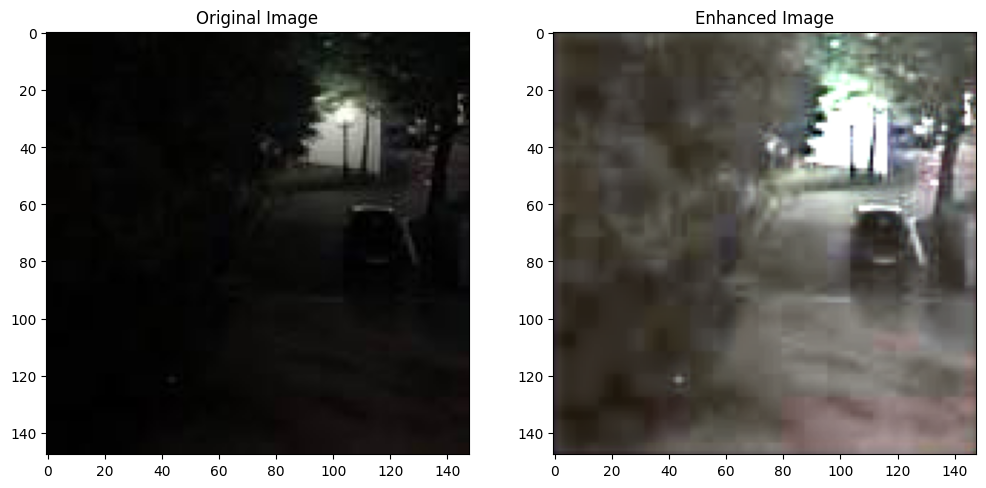

In [13]:
for image_path in LOW_LIGHT_IMGS[:10]:
    original_image, output_image = inferer.infer(image_path)
    plot_result(original_image, output_image)

In [14]:
import cv2
from PIL import Image
import numpy as np

In [15]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = image.resize((512, 512))
    image = np.array(image).astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    return image


In [16]:
def process_webcam_stream():
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        preprocessed_image = preprocess(frame)
        original_image, output_image = inferer.infer(preprocessed_image)
        output_image = np.transpose(output_image, (1, 2, 0))
        output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

        cv2.imshow("Low Light Image Enhancement", output_image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 124ms/step


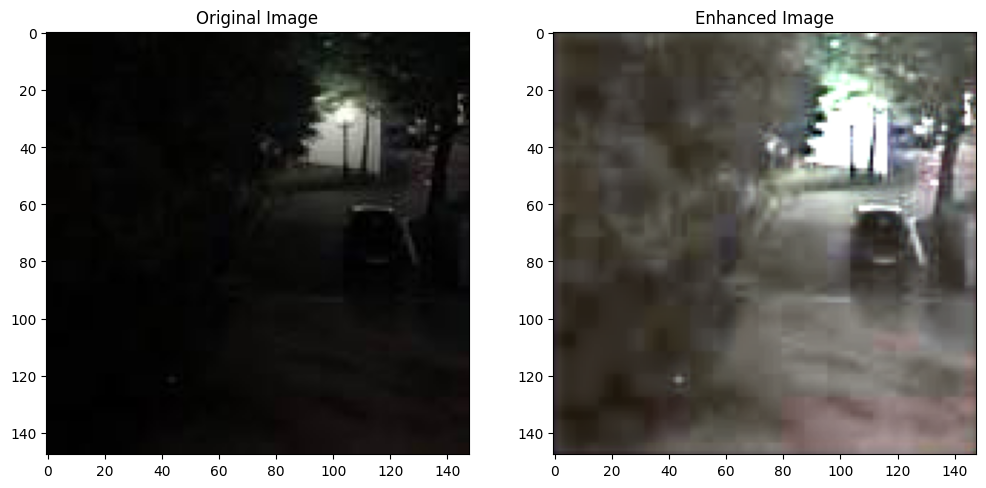

In [17]:
import cv2
from PIL import Image
import numpy as np

for image_path in LOW_LIGHT_IMGS[:10]:
    original_image, output_image = inferer.infer(image_path)
    plot_result(original_image, output_image)

def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = image.resize((512, 512))
    image = np.array(image).astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    return image

def process_webcam_stream():
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        preprocessed_image = preprocess(frame)
        original_image, output_image = inferer.infer(preprocessed_image)
        output_image = np.transpose(output_image, (1, 2, 0))
        output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

        cv2.imshow("Low Light Image Enhancement", output_image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    process_webcam_stream()


In [ ]:
import cv2
from glob import glob
from mirnet.train import LowLightTrainer
from mirnet.utils import init_wandb, download_dataset

# Download and prepare the dataset and initialize W&B
download_dataset('LOL')
init_wandb(project_name='mirnet', experiment_name='LOL_lowlight',
           wandb_api_key='62bf622d8bed093e638d2aa8550ed0737b9a636c')

# Load the trained model and define parameters

inferer = Inferer()
inferer.download_weights('1UCW9uBMBsd9EiK68nN_6ZlsEJE3kRD3m')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)
# Open a video capture device
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Preprocess the frame for the model
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (crop_size, crop_size))
    frame = frame.astype('float32') / 255.0

    # Apply the model to the frame
    output = inferer.predict(frame[None, ...])[0]

    # Postprocess the output and display it
    output = (output * 255.0).astype('uint8')
    output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    cv2.imshow('Output', output)

    # Wait for key press to exit
    if cv2.waitKey(1) == ord('q'):
        break

# Release the video capture device and close the windows
cap.release()
cv2.destroyAllWindows()
